In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.validation import _check_large_sparse
from sklearn.metrics import pairwise_distances_argmin_min, jaccard_score, f1_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import ClassifierChain


In [2]:
import random
def create_label_dict(filename:str):
    label_file = open(filename).readlines()
    labels = []
    filenames = []
    for i in range(len(label_file)):
        filenames.append(label_file[i].split(" ")[0])
        labels.append([int(l) for l in label_file[i].split(" ")[1:7]])
        # labels.append([random.randint(0, 1) for i in range(6)])
    return dict(zip(filenames, labels))

In [4]:
def count_label_dict(filename: str, counter: dict):
    label_file = open(filename).readlines()
    for i in range(len(label_file)):
        filename = label_file[i].split(" ")[0]
        # print(filename)
        counts = sum([int(l) for l in label_file[i].split(" ")[1:7]])
        # print(counts)
        counter[counts] += 1
    

In [3]:
train_labels = create_label_dict("./train_labels.txt")

In [4]:
test_labels = create_label_dict("./test_labels.txt")


In [6]:
label_counter = {i: 0 for i in range(0, 7)}
count_label_dict("./test_labels.txt", label_counter)
print(label_counter)
count_label_dict("./train_labels.txt", label_counter)
print(label_counter)


{0: 40, 1: 151, 2: 111, 3: 36, 4: 14, 5: 1, 6: 0}
{0: 75, 1: 368, 2: 315, 3: 147, 4: 55, 5: 8, 6: 0}


In [5]:
metadata_cols = ['frame', 'face_id', 'filename', 'timestamp']
train_df = pd.read_csv("./elder_train_dataset.csv", index_col=None)
feature_cols = list(set(train_df.columns) - set(metadata_cols) - set(['confidence','success']))
# train_means = train_df.groupby('filename')[feature_cols].mean()
tst_df = pd.read_csv("./elder_test_dataset.csv", index_col=None)
# tst_means = tst_df.groupby('filename')[feature_cols].mean()

In [62]:
tst_df

,filename,frame,face_id,timestamp,confidence,success,AU01_r,AU02_r,AU04_r,AU05_r,...,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,pose_Rx,pose_Ry,pose_Rz,gaze_angle_x,gaze_angle_y
0,50_50_17,2,1,0.042,0.98,1,1.31,0.94,0.38,1.25,...,0.04,0.00,0.12,0.00,0.00,0.406,-0.428,0.190,0.485,0.380
1,50_50_17,3,1,0.083,0.98,1,1.54,1.12,0.49,1.65,...,0.39,0.00,0.21,0.00,0.00,0.396,-0.405,0.177,0.468,0.376
2,50_50_17,4,1,0.125,0.98,1,1.58,1.13,0.64,1.28,...,0.43,0.00,0.12,0.00,0.00,0.375,-0.387,0.166,0.454,0.360
3,50_50_17,5,1,0.167,0.98,1,1.51,0.88,0.90,2.23,...,0.46,0.00,0.24,0.00,0.00,0.359,-0.384,0.159,0.451,0.348
4,50_50_17,6,1,0.209,0.98,1,1.56,0.86,0.75,1.87,...,0.79,0.00,0.23,0.00,0.00,0.344,-0.377,0.153,0.445,0.336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14046,vaping_for_the1st_98,112,0,4.630,0.98,1,0.33,0.84,1.87,0.00,...,0.97,0.00,0.57,1.75,0.99,0.091,0.165,0.073,-0.112,0.250
14047,vaping_for_the1st_98,113,0,4.671,0.98,1,0.38,1.02,1.88,0.00,...,0.68,0.00,0.54,1.99,0.83,0.116,0.172,0.048,-0.106,0.279
14048,vaping_for_the1st_98,114,0,4.713,0.98,1,0.41,0.91,2.06,0.00,...,0.70,0.09,0.45,2.32,0.91,0.115,0.176,0.030,-0.106,0.288
14049,vaping_for_the1st_98,115,0,4.755,0.98,1,0.41,0.75,2.06,0.00,...,1.11,0.00,0.65,1.95,0.96,0.099,0.176,0.061,-0.107,0.259


In [6]:
affects = ['anger','disgust','fear','happy','sad','surprise']
for a in affects:
    train_df[a] = np.NaN
    tst_df[a] = np.NaN
    # train_means[a] = np.NaN
    # tst_means[a] = np.NaN

In [7]:
for index, row in train_df.iterrows(): #TODO: change to train_df
    # print(index, row)
    filename = train_df.iloc[index]['filename']
    for i, name in enumerate(affects):
    # print(labels_expanded.loc[filename]['none':'hatred'].to_list())
        train_df.at[index, name] = train_labels[filename+'.mp4'][i] #TODO: change to train_df
        

In [8]:
for index, row in tst_df.iterrows(): #TODO: change to tst_df
    # print(index, row)
    filename = tst_df.iloc[index]['filename']
    for i, name in enumerate(affects):
    # print(labels_expanded.loc[filename]['none':'hatred'].to_list())
        tst_df.at[index, name] = test_labels[filename+'.mp4'][i]

In [9]:
cols_to_scale = list (
    set(train_df.columns.to_list()) - set(['frame', 'face_id', 'filename', 'timestamp', 'confidence','success'])
)
scaler = MinMaxScaler()
train_df[cols_to_scale] = scaler.fit_transform(train_df[cols_to_scale])
tst_df[cols_to_scale] = scaler.fit_transform(tst_df[cols_to_scale])



In [10]:
metadata_cols = ['frame', 'face_id', 'filename', 'timestamp']
test_videos = tst_df['filename'].unique()
train_videos = train_df['filename'].unique()
metadata_test = tst_df[metadata_cols]
train_df.dropna(inplace=True) #TODO: change to train_df
tst_df.dropna(inplace=True) #TODO: change to tst_df
y_test = tst_df[affects].values #TODO: change to tst_df
# np.random.shuffle(y_test)
# print(y_test[:10,:])
# X_test = tst_means.drop(columns = affects + ['filename']).values
X_test = tst_df.drop(columns = metadata_cols + ['confidence','success'] + affects).values #TODO: check and remove label columns if exist

In [58]:
len(X_test[1])

22

In [90]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier

kfold = KFold(5, True, 1)
frames_mean_hm_test = []
frames_mean_jac_test = []
videos_mean_jac_test = []
videos_mean_hm_test = []

col_indices = {i:label for (i,label) in enumerate(affects)}

splits = kfold.split(train_videos)
for (i, (train, valid)) in enumerate(splits):
    # print(videos[train])
    # print(videos[test])
    print('%d-th split: train: %d, test: %d' % (i+1, len(train_videos[train]), len(train_videos[valid])))
    train_cv_df = train_df[train_df['filename'].isin(train_videos[train])] #TODO: change to train_df
    # train_metadata = train_df[metadata_cols]
    print('Training+validation data size: ', len(train_videos))
    y_train = train_cv_df[affects].values
    # y_train = train_cv_df[affects].values
    # np.random.shuffle(y_train)
    ['frame' 'face_id' 'timestamp' 'confidence' 'success']
    # X_train = train_cv_df.drop(columns = ['frame', 'face_id', 'filename', 'timestamp', 'confidence','success']).values # TODO: check and drop affect columns
    X_train = train_cv_df.drop(columns = ['filename', 'frame', 'face_id', 'timestamp', 'confidence', 'success'] + affects).values # TODO: check and drop affect columns
    print("train df colus: ", train_cv_df.columns)
    valid_df = train_df[train_df['filename'].isin(train_videos[valid])] #TODO: check and drop affect colums - change to train_df
    # y_valid = valid_df[affects].values
    y_valid = valid_df[affects].values

    # X_valid = valid_df.drop(columns = ['frame', 'face_id', 'filename', 'timestamp', 'confidence','success']).values
    X_valid = valid_df.drop(columns = ['filename', 'frame', 'face_id', 'timestamp', 'confidence', 'success'] + affects).values

    print("Feature columns: ", X_valid.shape)
    # X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    print('Training data size: ', X_train.shape[0])
    print('Validation data size: ', X_valid.shape[0])
    base_knn =  KNeighborsClassifier(n_neighbors=5,)
    base_xgb = XGBClassifier(objective="binary:logistic", eval_metric='logloss')
    base_rf = RandomForestClassifier()

    # multiclass_xg = MultiOutputClassifier(XGBClassifier(objective='binary:logistic', eval_metric='auc'))
    # ovr = LogisticRegression()
    # multiclass_xg.fit(X_train, y_train)
    # valid_pred_xgb = multiclass_xg.predict(X_valid)
    # ovr_jaccard_score = jaccard_score(y_valid, valid_pred_xgb, average='samples') # TODO
    # ovr_ham_loss = metrics.hamming_loss(y_valid, valid_pred_xgb)
    # print("XGB-multi validation Jaccard score:" , ovr_jaccard_score)
    # print("XGB-multi validation Hamming loss: " , ovr_ham_loss)

    # Y_pred_ovr = multiclass_xg.predict(X_test)
    # a = jaccard_score(y_test, Y_pred_ovr, average='samples') #TODO
    # b = metrics.hamming_loss(y_test, Y_pred_ovr)
    # # print(Y_pred_ovr[800:805,:])
    # # print(y_test[800:805,:])

    # print("XGB-multi test Jaccard score: ", a)
    # print("XGB-multi test Hamming loss: " , b)

    chains = [ClassifierChain(base_xgb, order='random', random_state=i)
            for i in range(5)]
    best_model_index = 0
    best_jac = 0            
    for j, model in enumerate(chains):
        model.fit(X_train, y_train)
        valid_pred = model.predict(X_valid)
        val_score =jaccard_score(y_valid, valid_pred, average='samples')
        if val_score > best_jac:
            best_model_index = j
            best_jac = val_score

    # predict on validation data
    valid_pred_chains = chains[best_model_index].predict(X_valid)
    chain_jaccard_scores = jaccard_score(y_valid, valid_pred_chains >= .5, average='samples')
                    
    
    
    print("CC Validation Jaccard Score:\n ", chain_jaccard_scores)

    chain_hamming_loss =metrics.hamming_loss(y_valid, valid_pred_chains >= .5)
                
    print("CC Validation Hamming Loss:\n ", chain_hamming_loss)

    # test on test data
    Y_pred_chains = chains[best_model_index].predict(X_test)
    chain_jaccard_scores = jaccard_score(y_test, Y_pred_chains >= .5, average='samples') #TODO
                    
    frames_mean_jac_test.append(chain_jaccard_scores)
    print("CC Test Jaccard Score: \n ", chain_jaccard_scores)

    chain_hamming_loss = metrics.hamming_loss(y_test, Y_pred_chains) 
                
    frames_mean_hm_test.append(chain_hamming_loss)
    print("CC Test Hamming Loss:\n ", chain_hamming_loss)
    ## voting predicted labels
    # test_result_df = pd.DataFrame(columns=metadata_cols, data=metadata_test.values)
    # test_result_df.update(metadata_test)
    temp_df = pd.DataFrame(data=Y_pred_chains, columns=affects)
    test_result_df = pd.concat([metadata_test, temp_df], axis=1)
    video_groups = test_result_df.groupby('filename')[affects].sum()
    ground_truth_video_labels = []
    for v in video_groups.index.to_list():
        # number of 1s in ground truth labels
        ground_truth_video_labels.append(tst_df[tst_df['filename'] == v].iloc[0][affects])
        
        num_1s = tst_df[tst_df['filename'] == v].iloc[0][affects].sum()
        num_1s = int(num_1s)
        a = np.argsort(video_groups.loc[v].values)
        for i in range(len(a) - 1, len(a) - num_1s - 1, -1):
            video_groups.loc[v][a[i]] = 1
        for i in range(0, len(a) - num_1s):
            video_groups.loc[v][a[i]] = 0
        # print("          &&&&&&&&&&&&&&&&            ")
    print(np.array(ground_truth_video_labels,  dtype=int).shape)
    print(video_groups.values.shape)

    j = metrics.jaccard_score(np.array(ground_truth_video_labels,  dtype=int), video_groups.values, average='samples')
    h = metrics.hamming_loss(np.array(ground_truth_video_labels,  dtype=int), video_groups.values)
    videos_mean_jac_test.append(j)
    videos_mean_hm_test.append(h)

1-th split: train: 258, test: 65
Training+validation data size:  323
train df colus:  Index(['filename', 'frame', 'face_id', 'timestamp', 'confidence', 'success',
       'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r',
       'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r',
       'AU25_r', 'AU26_r', 'AU45_r', 'pose_Rx', 'pose_Ry', 'pose_Rz',
       'gaze_angle_x', 'gaze_angle_y', 'anger', 'disgust', 'fear', 'happy',
       'sad', 'surprise'],
      dtype='object')
Feature columns:  (10251, 22)
Training data size:  37093
Validation data size:  10251
XGB-multi validation Jaccard score: 0.32724124475660915
XGB-multi validation Hamming loss:  0.5041947127109551
XGB-multi test Jaccard score:  0.1701435349940688
XGB-multi test Hamming loss:  0.5262870699881376
CC Validation Jaccard Score:
  0.3293873768412838
CC Validation Hamming Loss:
  0.506438396254024
CC Test Jaccard Score: 
  0.16826809015421115
CC Test Hamming Loss:
  0.519620403321471
(95, 6

In [91]:
print(metrics.classification_report(np.array(ground_truth_video_labels,  dtype=int),  video_groups.values, target_names=affects))
print(metrics.classification_report(y_test,  Y_pred_chains, target_names=affects))


              precision    recall  f1-score   support

       anger       0.24      0.40      0.30        15
     disgust       0.20      0.29      0.24        14
        fear       0.21      0.75      0.32         8
       happy       0.53      0.18      0.27        44
         sad       0.69      0.43      0.53        21
    surprise       0.38      0.38      0.38        24

   micro avg       0.33      0.33      0.33       126
   macro avg       0.37      0.40      0.34       126
weighted avg       0.44      0.33      0.34       126
 samples avg       0.20      0.20      0.20       126

              precision    recall  f1-score   support

       anger       0.17      0.53      0.25      2501
     disgust       0.10      0.36      0.15      1818
        fear       0.08      0.62      0.14      1113
       happy       0.46      0.49      0.47      6196
         sad       0.23      0.36      0.28      3369
    surprise       0.24      0.46      0.31      3448

   micro avg       0.20

In [ ]:
metrics.jaccard_score([0, 0, 0, 0], [0, 0, 0, 0])

In [ ]:
c = 0
for i in range(len(y_test)):
    # print(sum(y_test[i]))
    if  metrics.jaccard_score(y_test[i], Y_pred_chains[0][i]) < 1.0:
        c += 1
print(c)

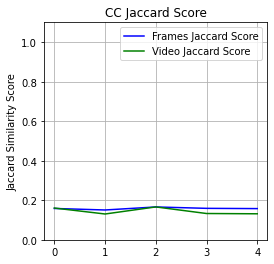

In [74]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('CC Jaccard Score')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Jaccard Similarity Score')
ax.set_ylim([0.0, 1.1])

plt.plot(frames_mean_jac_test, label='Frames Jaccard Score', color='blue')
plt.plot(videos_mean_jac_test, label='Video Jaccard Score', color='green')
plt.legend(loc='best')
plt.show()

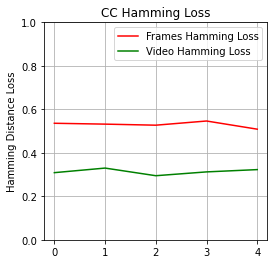

In [76]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('CC Hamming Loss')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Hamming Distance Loss')
ax.set_ylim([0.00, 1.0])
# ax.legend(('Frames Hamming Loss','Video Hamming Loss' ))
plt.plot(frames_mean_hm_test, label='Frames Hamming Loss', color='red')
plt.plot(videos_mean_hm_test, label='Video Hamming Loss', color='green')
plt.legend(loc='upper right')
plt.show()

In [77]:
from skmultilearn.adapt import MLkNN
import sklearn.metrics as metrics

kfold = KFold(5, True, 1)
frames_mean_hm_test = []
frames_mean_jac_test = []
videos_mean_jac_test = []
videos_mean_hm_test = []
col_indices = {i:label for (i,label) in enumerate(affects)}

splits = kfold.split(train_videos)
for (i, (train, test)) in enumerate(splits):
    train_cv_df = train_df[train_df['filename'].isin(train_videos[train])]
    train_metadata = train_df[metadata_cols]
    y_train = train_cv_df[affects].values
    X_train = train_cv_df.drop(columns = ['frame', 'face_id', 'filename', 'timestamp', 'confidence','success']).values
    valid_df = train_df[train_df['filename'].isin(train_videos[test])]
    y_valid = valid_df[affects].values
    X_valid = valid_df.drop(columns = ['frame', 'face_id', 'filename', 'timestamp', 'confidence','success']).values
    # X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    print('%d-th split: train: %d, validation: %d' % (i+1, X_train.shape[0],  X_valid.shape[0]))
    classifier = MLkNN(k=5)
    # classifier = MLTSVM(c_k = 2**-1)
    prediction = classifier.fit(X_train, y_train).predict(X_valid)

    # Predicting on validation set
    print("Validation Hamming Loss:\n ", metrics.hamming_loss(y_valid, prediction))

    # Predicting on test set
    y_test_pred = classifier.predict(X_test)
    hm_loss = metrics.hamming_loss(y_test, y_test_pred)
    frames_mean_hm_test.append(hm_loss)
    print("Test Hamming Loss:\n ", hm_loss)
    jac_score = jaccard_score(y_test, y_test_pred,  average='samples')
    frames_mean_jac_test.append(jac_score)
    print("Test Jaccard Score:\n ", jac_score)

    # building test dataframe to vote labels
    # test_result_df = pd.DataFrame(columns=metadata_cols, data=metadata_test.values)
    # test_result_df.update(metadata_test)
    # # print("^^^^^^^^", y_test_pred.toarray().shape)
    # temp_df = pd.DataFrame(data=y_test_pred.toarray(), columns=affects)
    # test_result_df = pd.concat([test_result_df, temp_df], axis=1)
    
    # print(test_result_df.head())
    # video_groups = test_result_df.groupby('filename')[affects].apply(lambda x : x.astype(int).sum())
    # for name, group in video_groups:
    #     print(name)
    #     print(group)
    #     print("\n") 
    # ground_truth_video_labels = []
    # for v in video_groups.index.to_list():
    #     # number of 1s in ground truth labels
    #     ground_truth_video_labels.append(tst_df[tst_df['filename'] == v].iloc[0][affects])
    #     num_1s = tst_df[tst_df['filename'] == v].iloc[0][affects].sum()
    #     num_1s = int(num_1s)
    #     a = np.argsort(video_groups.loc[v].values)
    #     for i in range(len(a) - 1, len(a) - num_1s - 1, -1):
    #         video_groups.loc[v][a[i]] = 1
    #     for i in range(0, len(a) - num_1s):
    #         video_groups.loc[v][a[i]] = 0

    # j = metrics.jaccard_score(np.array(ground_truth_video_labels,  dtype=int), video_groups.values, average='samples')
    # h = metrics.hamming_loss(np.array(ground_truth_video_labels,  dtype=int), video_groups.values)
    # videos_mean_jac_test.append(j)
    # videos_mean_hm_test.append(h)

1-th split: train: 37093, validation: 10251
Validation Hamming Loss:
  0.22713231229473546


ValueError: query data dimension must match training data dimension

In [ ]:
print(metrics.classification_report(y_test, y_test_pred, target_names=affects))


In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('MLKNN Jaccard Score')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Jaccard Similarity Score')
ax.set_ylim([0.65, 1.0])

plt.plot(frames_mean_jac_test, label='Frames Jaccard Score', color='blue')
plt.plot(videos_mean_jac_test, label='Video Jaccard Score', color='green')
plt.legend(loc='lower right')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('MLKNN Hamming Loss')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Hamming Distance Loss')
ax.set_ylim([0.00, .1])
# ax.legend(('Frames Hamming Loss','Video Hamming Loss' ))
plt.plot(frames_mean_hm_test, label='Frames Hamming Loss', color='red')
plt.plot(videos_mean_hm_test, label='Video Hamming Loss', color='green')
plt.legend(loc='upper right')
plt.show()